Lets look at the distribution of the image dimensions from the kaggle dataset

Width stats:
  Min: 85
  Max: 6215
  Mean: 782.60
  Median: 656.00
  Standard deviation: 518.10
Height stats:
  Min: 47
  Max: 5850
  Mean: 768.20
  Median: 636.00
  Standard deviation: 532.55
Aspect Ratio stats:
  Min: 0.16885553470919323
  Max: 11.340425531914894
  Mean: 1.10
  Median: 1.07
  Standard deviation: 0.44

Most common image sizes:
  416x335: 23
  416x290: 19
  416x305: 15
  416x325: 14
  673x833: 14
  330x416: 14
  662x833: 13
  296x416: 13
  335x416: 13
  416x340: 12

Total number of images analyzed: 10013


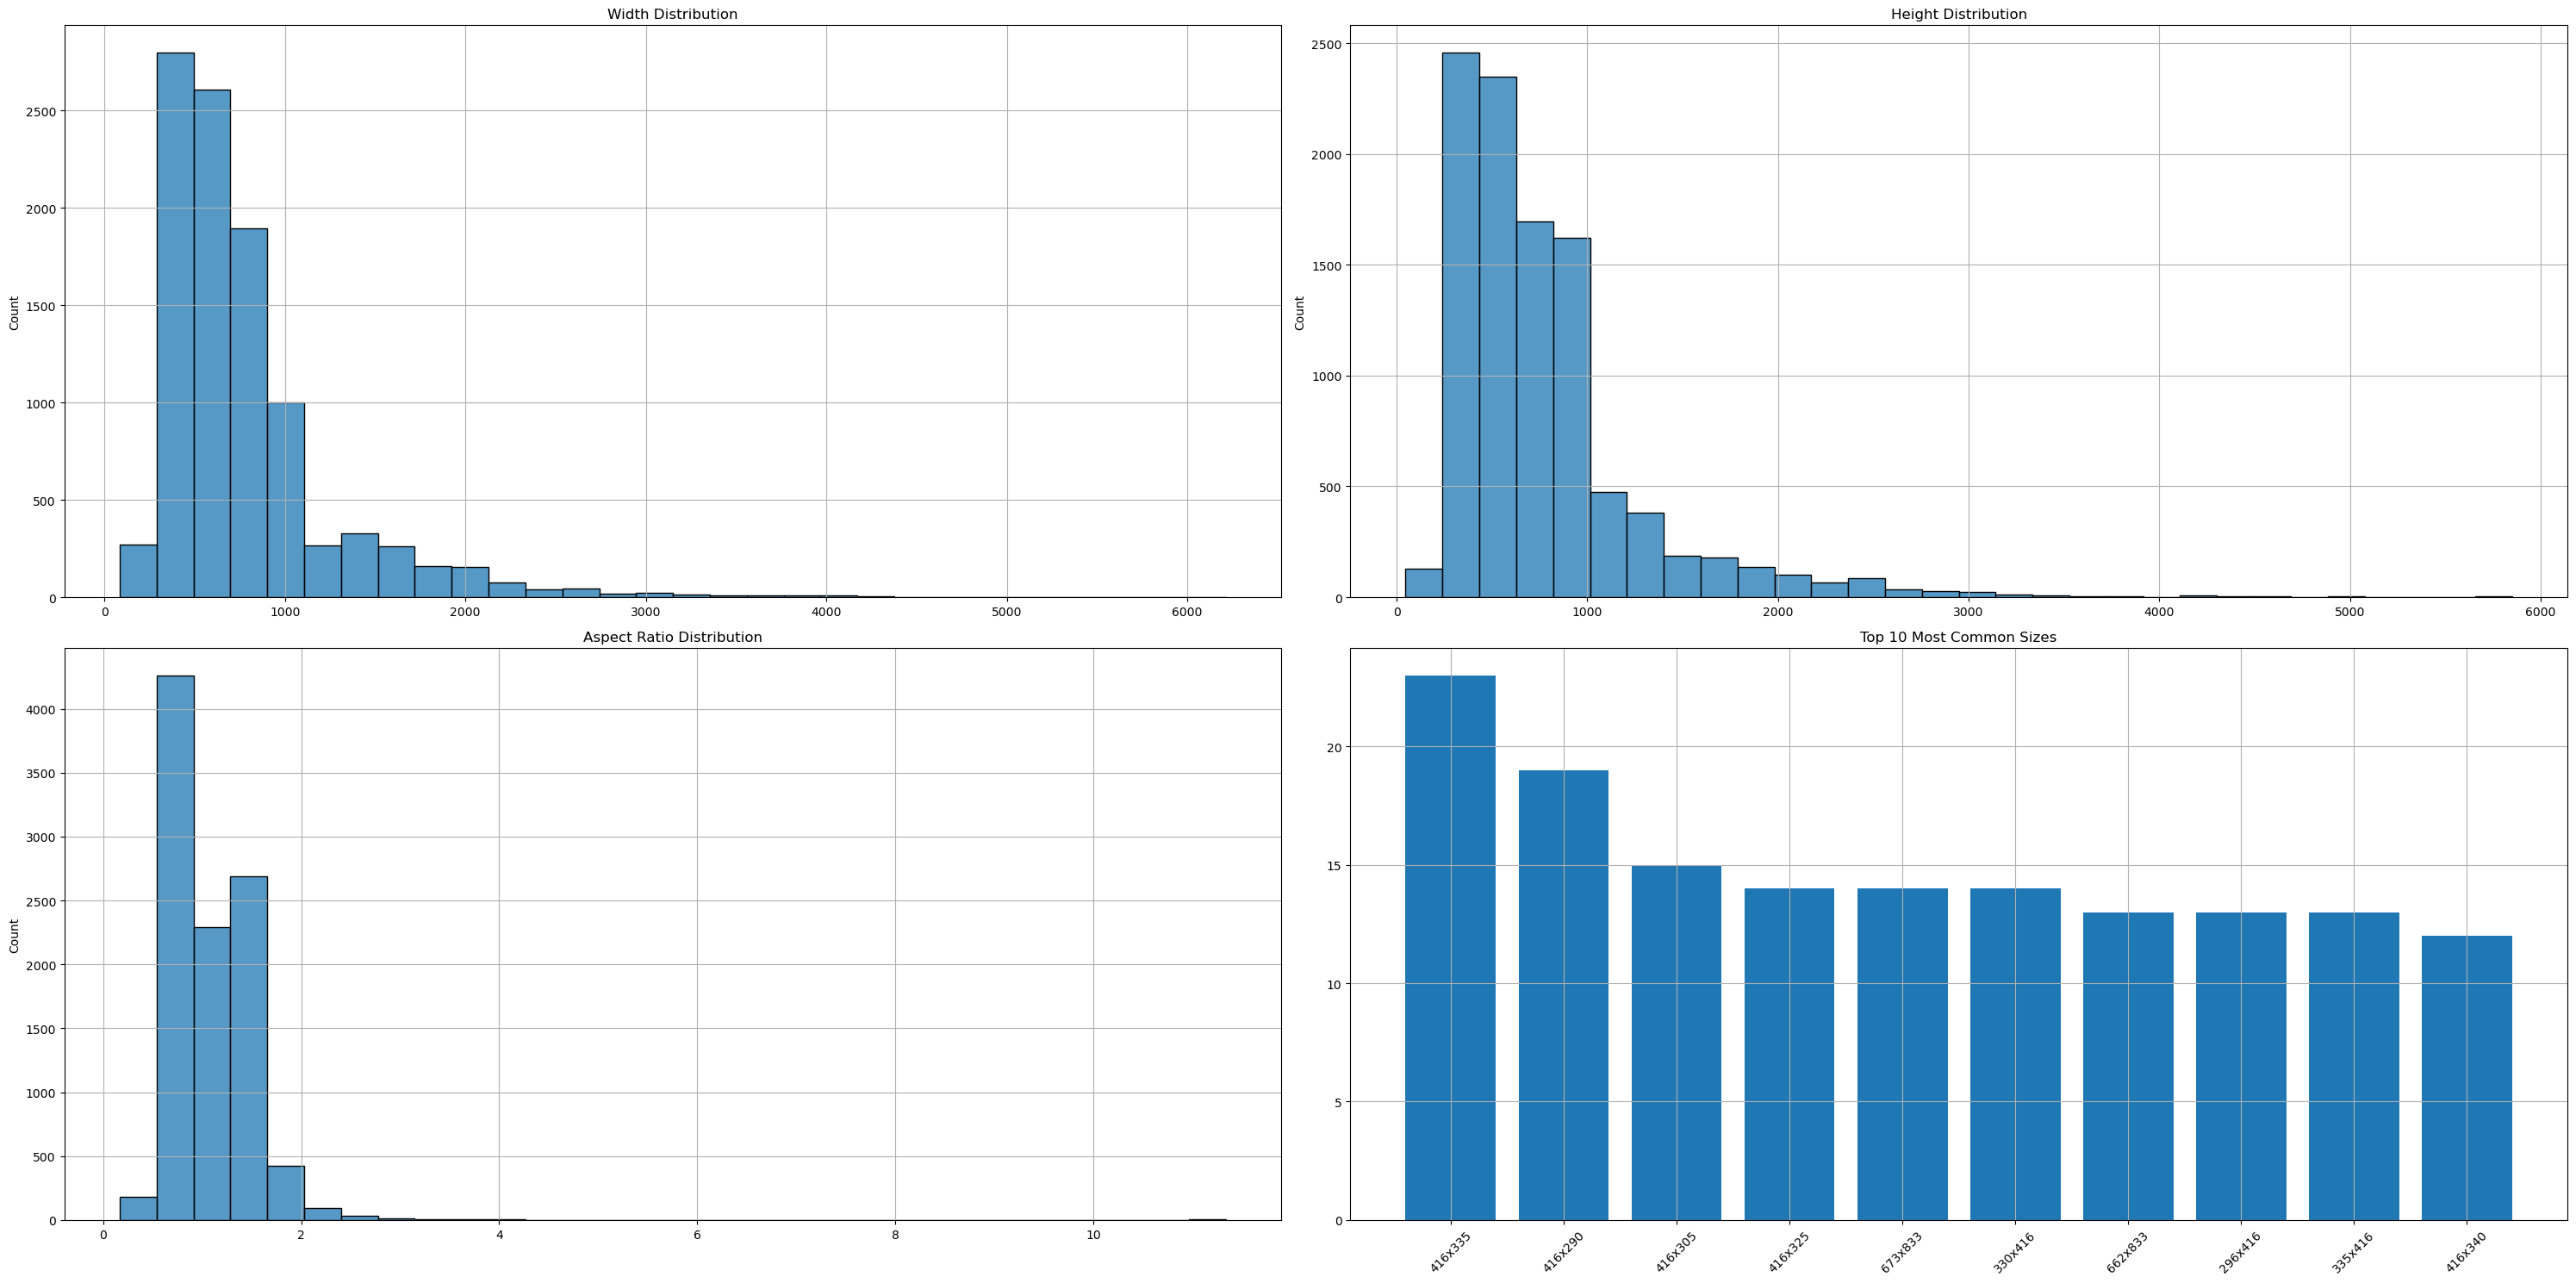

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def analyze_images(directory):
    widths = []
    heights = []
    aspect_ratios = []
    sizes = defaultdict(int)

    # Process all image files in directory
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                try:
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        width, height = img.size
                        aspect_ratio = width / height

                        widths.append(width)
                        heights.append(height)
                        aspect_ratios.append(aspect_ratio)
                        sizes[f"{width}x{height}"] += 1
                except Exception as e:
                    print(f"Error processing {os.path.basename(img_path)}: {str(e)}")

    return widths, heights, aspect_ratios, sizes

def print_stats(data, name):
    print(f"{name} stats:")
    print(f"  Min: {min(data)}")
    print(f"  Max: {max(data)}")
    print(f"  Mean: {np.mean(data):.2f}")
    print(f"  Median: {np.median(data):.2f}")
    print(f"  Standard deviation: {np.std(data):.2f}")

def plot_distributions(widths, heights, aspect_ratios, sizes):
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))
    
    # Plot distributions
    sns.histplot(widths, bins=30, ax=axs[0,0])
    axs[0,0].set_title('Width Distribution')
    axs[0,0].grid(True)
    
    sns.histplot(heights, bins=30, ax=axs[0,1])
    axs[0,1].set_title('Height Distribution')
    axs[0,1].grid(True)
    
    sns.histplot(aspect_ratios, bins=30, ax=axs[1,0])
    axs[1,0].set_title('Aspect Ratio Distribution')
    axs[1,0].grid(True)
    
    # Plot top 10 most common sizes
    top_sizes = dict(sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:10])
    axs[1,1].bar(range(len(top_sizes)), list(top_sizes.values()))
    axs[1,1].set_xticks(range(len(top_sizes)))
    axs[1,1].set_xticklabels(list(top_sizes.keys()), rotation=45)
    axs[1,1].set_title('Top 10 Most Common Sizes')
    axs[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

image_directory = 'mask_images/inpainting'

# Analyze images
widths, heights, aspect_ratios, sizes = analyze_images(image_directory)

# Print statistics
print_stats(widths, "Width")
print_stats(heights, "Height")
print_stats(aspect_ratios, "Aspect Ratio")

print("\nMost common image sizes:")
for size, count in sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {size}: {count}")

print(f"\nTotal number of images analyzed: {len(widths)}")

# Plot distributions
plot_distributions(widths, heights, aspect_ratios, sizes)

Next we will analyse compare varies metrics between original and masked images to see if there is any relationship between them

In [9]:
import cv2
from scipy import stats
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_single_pair(args):
    """
    Analyze a single pair of images
    
    Args:
        args: tuple of (original_path, processed_path)
    Returns:
        tuple: (success, metrics dictionary)
    """
    original_path, processed_path = args
    try:
        # Load images
        original = cv2.imread(original_path)
        processed = cv2.imread(processed_path)
        
        if original is None or processed is None:
            return False, None
            
        # Convert to various color spaces for analysis
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
        processed_gray = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)
        original_hsv = cv2.cvtColor(original, cv2.COLOR_BGR2HSV)
        processed_hsv = cv2.cvtColor(processed, cv2.COLOR_BGR2HSV)
        
        metrics = {}
        
        # 1. Basic Image Statistics
        metrics['original_mean_brightness'] = float(np.mean(original_gray))
        metrics['processed_mean_brightness'] = float(np.mean(processed_gray))
        metrics['original_std_brightness'] = float(np.std(original_gray))
        metrics['processed_std_brightness'] = float(np.std(processed_gray))
        
        # 2. Color Distribution
        for i, channel in enumerate(['hue', 'saturation', 'value']):
            metrics[f'original_mean_{channel}'] = float(np.mean(original_hsv[:,:,i]))
            metrics[f'processed_mean_{channel}'] = float(np.mean(processed_hsv[:,:,i]))
            metrics[f'original_std_{channel}'] = float(np.std(original_hsv[:,:,i]))
            metrics[f'processed_std_{channel}'] = float(np.std(processed_hsv[:,:,i]))
        
        # 3. Texture Analysis
        metrics['original_entropy'] = float(stats.entropy(np.histogram(original_gray, bins=256)[0]))
        metrics['processed_entropy'] = float(stats.entropy(np.histogram(processed_gray, bins=256)[0]))
        
        # 4. Masked Region Analysis
        diff = cv2.absdiff(original_gray, processed_gray)
        _, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
        metrics['masked_area_percentage'] = float((np.sum(mask > 0) / mask.size) * 100)
        
        # 5. Image Quality Metrics
        metrics['ssim'] = float(ssim(original_gray, processed_gray))
        
        # 6. Edge Detection Analysis
        original_edges = cv2.Canny(original_gray, 100, 200)
        processed_edges = cv2.Canny(processed_gray, 100, 200)
        metrics['original_edge_density'] = float(np.sum(original_edges > 0) / original_edges.size)
        metrics['processed_edge_density'] = float(np.sum(processed_edges > 0) / processed_edges.size)
        
        return True, metrics
        
    except Exception as e:
        print(f"Error processing {os.path.basename(processed_path)}: {str(e)}")
        return False, None

# Prepare image pairs
def get_image_pairs(original_dir, processed_dir):
    """Get list of image pairs to process"""
    image_pairs = []
    for filename in os.listdir(processed_dir):
        if filename.startswith('inpainting_'):
            number = filename.split('_')[1]
            original_name = f'original_{number}'
            original_path = os.path.join(original_dir, original_name)
            processed_path = os.path.join(processed_dir, filename)
            
            if os.path.exists(original_path):
                image_pairs.append((original_path, processed_path))
    return image_pairs

# Main analysis function
def analyze_dataset(original_dir, processed_dir):
    """
    Analyze entire dataset using parallel processing with tqdm
    """
    # Get list of image pairs
    image_pairs = get_image_pairs(original_dir, processed_dir)
    
    all_metrics = []
    summary_stats = defaultdict(list)
    
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        # Process all pairs and collect results with progress bar
        results = list(tqdm.tqdm(
            executor.map(analyze_single_pair, image_pairs),
            total=len(image_pairs),
            desc="Analyzing images"
        ))
    
    # Process results
    successful = 0
    failed = 0
    for success, metrics in results:
        if success and metrics:
            successful += 1
            all_metrics.append(metrics)
            for key, value in metrics.items():
                summary_stats[key].append(value)
        else:
            failed += 1
    
    # Print summary
    print(f"\nProcessed {successful} pairs successfully")
    if failed > 0:
        print(f"Failed to process {failed} pairs")
    
    return all_metrics, summary_stats

# Usage
original_dir = 'extracted_images/original'
processed_dir = 'extracted_images/inpainting'

# Run analysis
metrics, summary = analyze_dataset(original_dir, processed_dir)

Analyzing images: 100%|██████████| 5063/5063 [03:56<00:00, 21.38it/s]


Processed 5063 pairs successfully


C:\Users\cheng\AppData\Local\Temp\ipykernel_35684\1484918742.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([summary_stats['original_edge_density'],


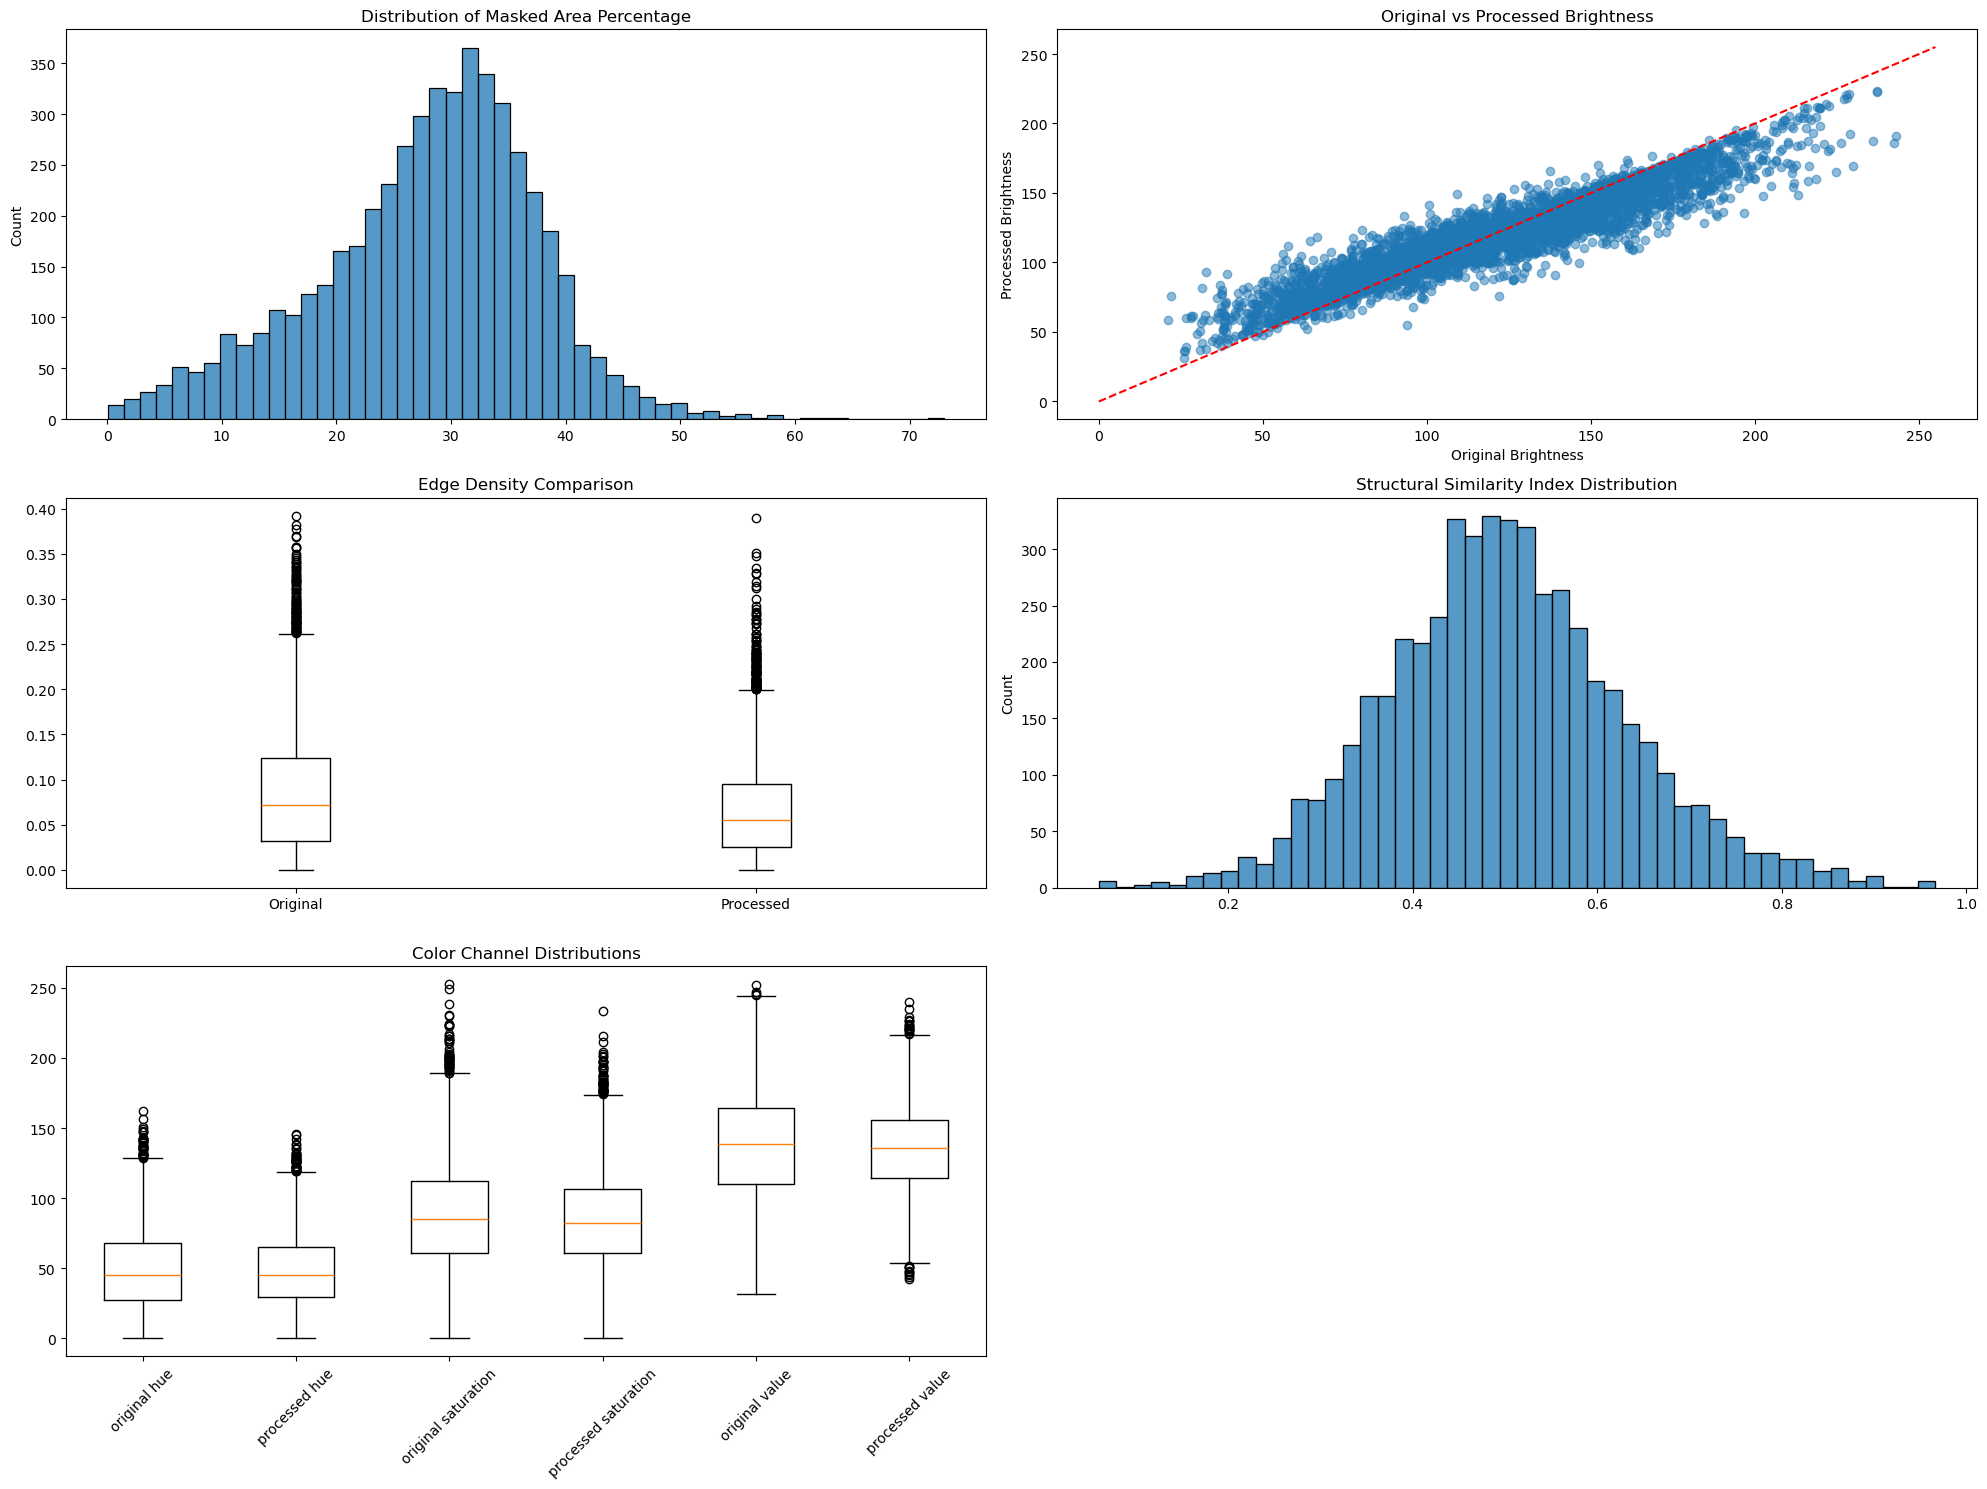

In [10]:
def plot_analysis_results(summary_stats):
    """
    Create visualizations of the analysis results
    """
    if not summary_stats or not any(summary_stats.values()):
        print("No data to plot!")
        return
    
    # Create subplots for different metrics
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Masked Area Distribution
    plt.subplot(3, 2, 1)
    sns.histplot(summary_stats['masked_area_percentage'])
    plt.title('Distribution of Masked Area Percentage')
    
    # 2. Brightness Changes
    plt.subplot(3, 2, 2)
    plt.scatter(summary_stats['original_mean_brightness'], 
            summary_stats['processed_mean_brightness'],
            alpha=0.5)
    plt.plot([0, 255], [0, 255], 'r--')
    plt.xlabel('Original Brightness')
    plt.ylabel('Processed Brightness')
    plt.title('Original vs Processed Brightness')
    
    # 3. Edge Density Changes
    plt.subplot(3, 2, 3)
    plt.boxplot([summary_stats['original_edge_density'], 
                summary_stats['processed_edge_density']], 
                labels=['Original', 'Processed'])
    plt.title('Edge Density Comparison')
    
    # 4. SSIM Distribution
    plt.subplot(3, 2, 4)
    sns.histplot(summary_stats['ssim'])
    plt.title('Structural Similarity Index Distribution')
    
    # 5. Color Changes (HSV)
    plt.subplot(3, 2, 5)
    hsv_data = [summary_stats[f'{orig_proc}_mean_{channel}'] 
                for channel in ['hue', 'saturation', 'value']
                for orig_proc in ['original', 'processed']]
    labels = [f'{orig_proc} {channel}' 
            for channel in ['hue', 'saturation', 'value']
            for orig_proc in ['original', 'processed']]
    plt.boxplot(hsv_data)
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
    plt.title('Color Channel Distributions')
    
    plt.tight_layout()
    plt.show()

# Plot results if we have data
if metrics:
    plot_analysis_results(summary)
else:
    print("No data to analyze!")


When resizing images, we want to preserve the important details of an image. We choose to use Lanczos resampling for this. The difference between regular resizing and Lanczos can be seen here

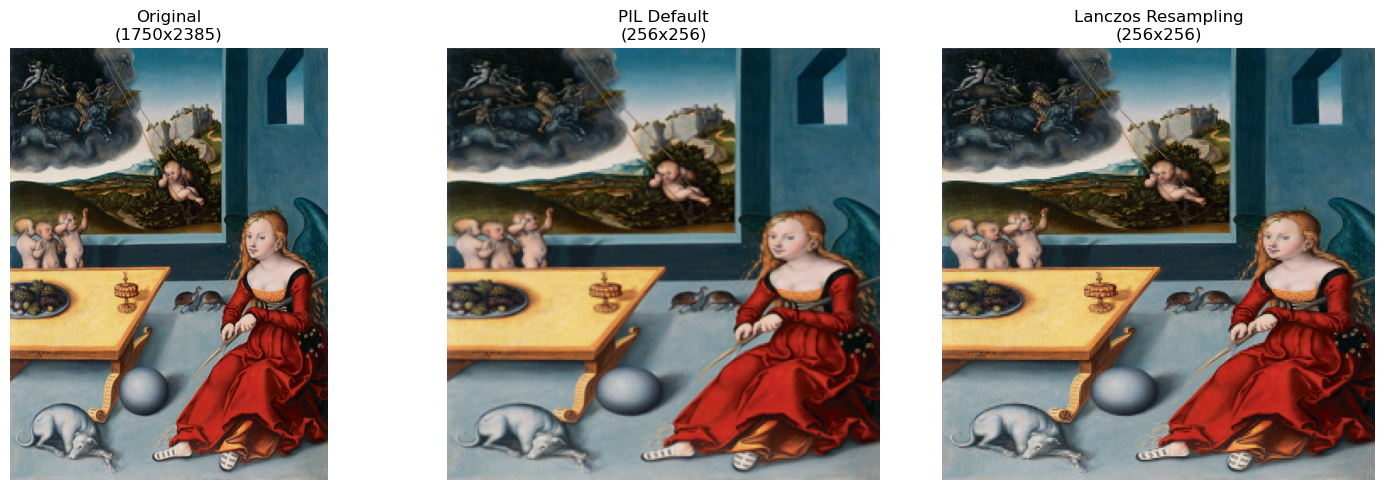

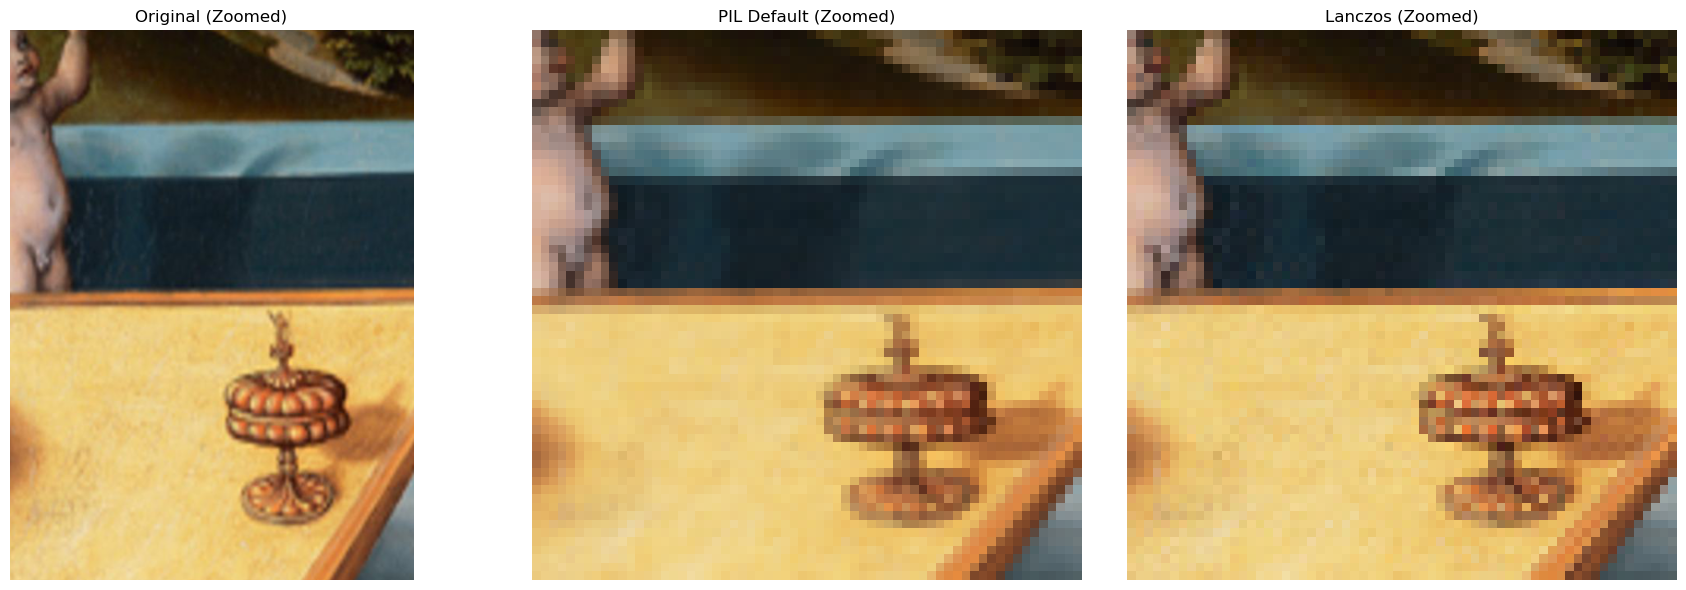

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

def compare_resizing_methods(image_path):
    # Load original image
    original = Image.open(image_path)
    original = original.convert('RGB')
    original_array = np.array(original)
    
    # Get original size for reference
    original_size = original.size
    
    # Method 1: PIL default resize
    pil_resized = original.resize((256, 256))
    pil_array = np.array(pil_resized)
    
    # Method 2: Lanczos resampling
    img_array = np.array(original)
    # Convert to BGR before resize
    img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    lanczos_resized = cv2.resize(
        img_array,
        (256, 256),
        interpolation=cv2.INTER_LANCZOS4
    )
    # Convert back to RGB for display
    lanczos_resized = cv2.cvtColor(lanczos_resized, cv2.COLOR_BGR2RGB)
    
    # Create subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original
    axes[0].imshow(original_array)
    axes[0].set_title(f'Original\n({original_size[0]}x{original_size[1]})')
    axes[0].axis('off')
    
    # Plot PIL resized
    axes[1].imshow(pil_array)
    axes[1].set_title('PIL Default\n(256x256)')
    axes[1].axis('off')
    
    # Plot Lanczos resized
    axes[2].imshow(lanczos_resized)
    axes[2].set_title('Lanczos Resampling\n(256x256)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show zoomed in versions
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Zoom into a portion of each resized image
    zoom_size = 64  # Size of zoomed region
    start_x, start_y = 50, 100  # Starting point of zoom
    
    # Calculate scaling factor for original image zoom
    scale_x = original_size[0] / 256
    scale_y = original_size[1] / 256
    orig_start_x = int(start_x * scale_x)
    orig_start_y = int(start_y * scale_y)
    orig_zoom_size_x = int(zoom_size * scale_x)
    orig_zoom_size_y = int(zoom_size * scale_y)
    
    # Plot zoomed original
    axes[0].imshow(original_array[orig_start_y:orig_start_y+orig_zoom_size_y, 
                                orig_start_x:orig_start_x+orig_zoom_size_x])
    axes[0].set_title('Original (Zoomed)')
    axes[0].axis('off')
    
    # Plot zoomed PIL
    axes[1].imshow(pil_array[start_y:start_y+zoom_size, start_x:start_x+zoom_size])
    axes[1].set_title('PIL Default (Zoomed)')
    axes[1].axis('off')
    
    # Plot zoomed Lanczos
    axes[2].imshow(lanczos_resized[start_y:start_y+zoom_size, start_x:start_x+zoom_size])
    axes[2].set_title('Lanczos (Zoomed)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Use the function with one of your images
image_path = "extracted_images/original/original_20.png"
compare_resizing_methods(image_path)